<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#New" data-toc-modified-id="New-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>New</a></span><ul class="toc-item"><li><span><a href="#Debug-code" data-toc-modified-id="Debug-code-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Debug code</a></span></li><li><span><a href="#Sin-trajectory" data-toc-modified-id="Sin-trajectory-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Sin trajectory</a></span></li><li><span><a href="#No-non-pred" data-toc-modified-id="No-non-pred-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>No non-pred</a></span></li><li><span><a href="#Demon" data-toc-modified-id="Demon-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Demon</a></span></li><li><span><a href="#Demon-and-without-non-ident" data-toc-modified-id="Demon-and-without-non-ident-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Demon and without non-ident</a></span></li></ul></li><li><span><a href="#Old" data-toc-modified-id="Old-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Old</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1" data-toc-modified-id="1-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>1</a></span></li><li><span><a href="#2" data-toc-modified-id="2-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>2</a></span></li><li><span><a href="#3" data-toc-modified-id="3-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>3</a></span></li></ul></li><li><span><a href="#Quantiles" data-toc-modified-id="Quantiles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Quantiles</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tqdm.auto import tqdm

import random

In [2]:
from sklearn.cluster import DBSCAN

from src.Lorentz import Lorentz
from src.TSProcessor import TSProcessor

%load_ext autoreload
%autoreload 2

In [207]:
from src.utils import normalize, denormalize, plot_trajectories

## New

split into train and test

train = 3/4 of data
test = 1/4 of data

### Debug code

In [85]:
x = np.array(list(range(1, 31))).astype(np.float32)

In [86]:
tsp = TSProcessor(points_in_template=3, max_template_spread=4)

In [87]:
tsp.fit(x)

In [114]:
X_start = x[5:13]
h_max = 3
# X_test = np.repeat(np.nan, h_max) # maybe rename to X_fill

In [115]:
tsp._training_vectors.shape # templates x vectors x obs

(16, 28, 3)

In [137]:
tsp.predict(X_start, X_test, method='cluster', n_trajectories=10)

0.51s


(array([[14.08820262, 14.08121727, 13.97916211, 14.08943142, 14.00252809,
         14.02206137, 13.98441082, 14.08452629, 14.00456024, 14.00005543],
        [15.02000786, 14.96941218, 14.99718666, 15.02182549, 15.02499757,
         14.98345649, 15.0364502 , 14.97670313, 15.05456414, 14.9855228 ],
        [16.0489369 , 15.97359141, 15.8931902 , 16.00482487, 15.95020455,
         16.12153856, 16.01089104, 16.00164101, 15.90265148, 15.94419668]]),
 array([14.0858444 , 14.97877365,         nan]))

In [127]:
a = np.array([
    [1, 2],
    [3, 4],
    [5, 6],
])
a = a[:, np.newaxis, :]
a.shape

(3, 1, 2)

In [128]:
b = np.repeat(a, 4, axis=1)
b.shape

(3, 4, 2)

In [129]:
(b ** 2).sum(axis=-1)

array([[ 5,  5,  5,  5],
       [25, 25, 25, 25],
       [61, 61, 61, 61]])

### Sin trajectory

In [315]:
train_size = 600
test_size = 200
h_max = 50 # max prediction horizon (t+h)

points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11

eps   = 0.01
n_trajectories = 24
noise_amp = 0.03

dbs_eps = 0.01
dbs_min_samples = 4

In [316]:
x = np.sin(np.linspace(0, 8*np.pi, train_size+test_size))
x, x_min, x_max = normalize(x)

In [317]:
X_train = x[:train_size]
X_test = x[train_size:]

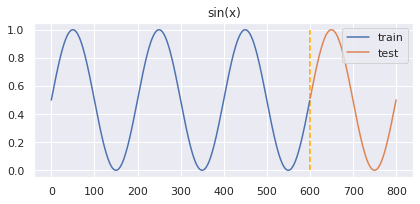

In [318]:
fig = plt.figure(figsize=[6, 3])
plt.plot(X_train, label='train')
plt.plot(range(train_size, train_size+test_size), X_test, label='test')

plt.title('sin(x)')

plt.vlines(train_size, 0, 1,
           color='orange', linestyle='dashed')

plt.legend();
fig.tight_layout()

In [319]:
tsp = TSProcessor(points_in_template=points_in_template, max_template_spread=max_template_spread)

In [320]:
tsp.fit(X_train)

In [321]:
X_start = X_train[-max_template_spread * (points_in_template-1):]
X_fill = np.repeat(np.nan, h_max)

In [330]:
X_traj_pred, X_pred = tsp.predict(
    X_start, X_test, method='cluster',
    n_trajectories=n_trajectories)

29.02s


In [331]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test)**2), nan=0)) /pred

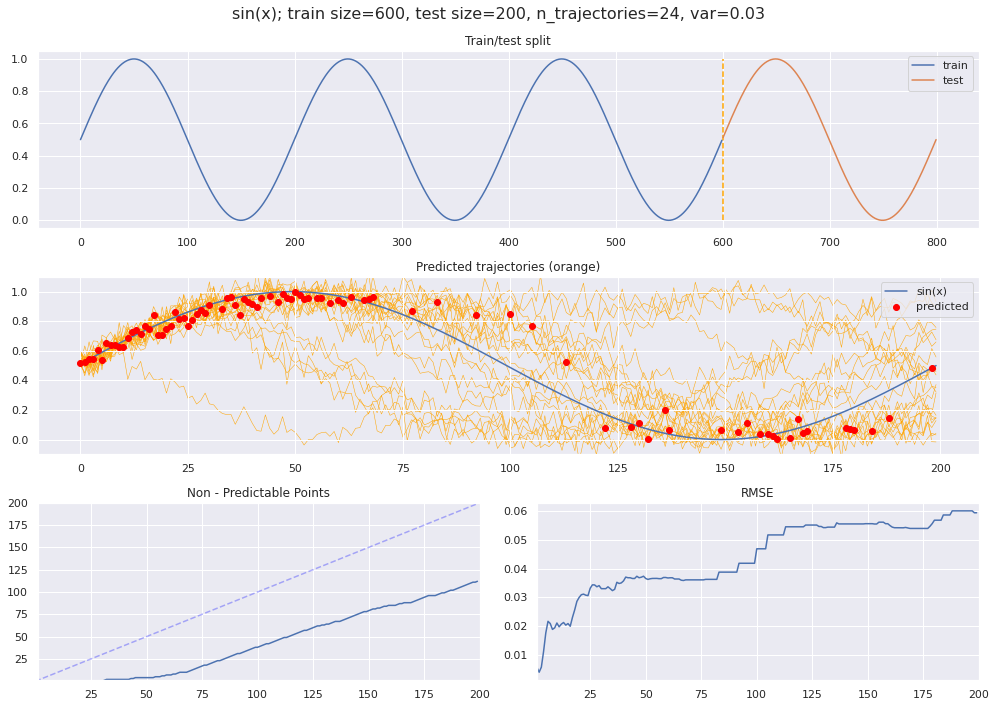

In [332]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

### No non-pred

In [333]:
X_traj_pred, X_pred = tsp.predict(X_start, X_test, method='no-np')

3.35s


In [334]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test)**2), nan=0)) /pred

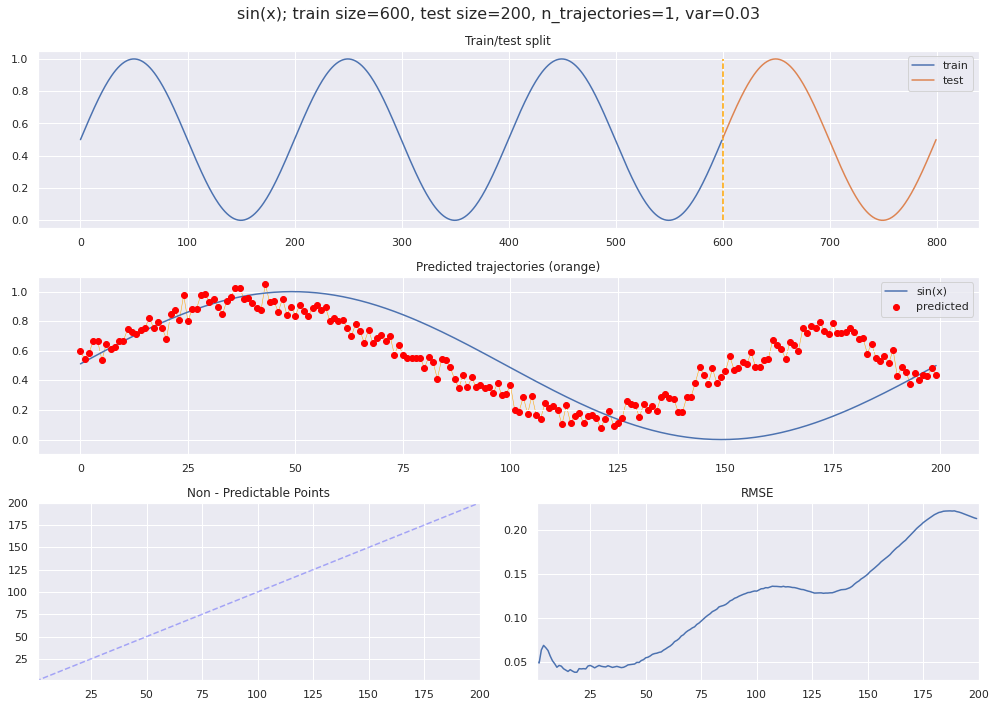

In [335]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, 1,
    X_traj_pred, X_pred, non_pred, rmse
)

### Demon

In [336]:
X_train = x[:train_size]
X_test = x[train_size:]

In [337]:
tsp = TSProcessor(points_in_template=points_in_template, max_template_spread=max_template_spread)

In [338]:
tsp.fit(X_train)

In [339]:
X_start = X_train[-max_template_spread * (points_in_template-1):]
X_fill = np.repeat(np.nan, h_max)

In [343]:
X_traj_pred, X_pred = tsp.predict(
    X_start, X_test, method='priori',
    n_trajectories=n_trajectories
)

30.89s


In [344]:
non_pred = np.cumsum(np.isnan(X_pred).astype(int))
pred = np.cumsum(1 - np.isnan(X_pred).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((X_pred - X_test)**2), nan=0)) /pred

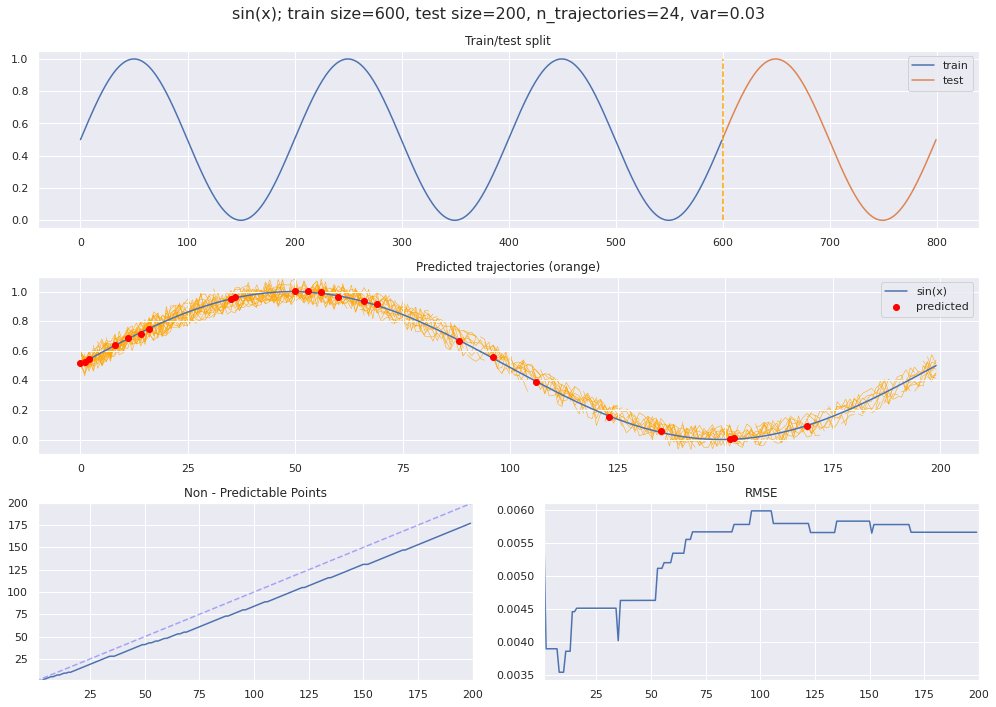

In [345]:
plot_trajectories(
    'sin(x)', X_train, X_test,
    noise_amp, n_trajectories,
    X_traj_pred, X_pred, non_pred, rmse
)

### Demon and without non-ident

In [164]:
train_size = 1000
test_size = 100
h_max = 50 # max prediction horizon (t+h)

points_in_template = 4
max_template_spread = 10 # max distance between y_t1 and y_t2, y_1 and y_11

eps   = 0.01
n_trajectories = 10
noise_amp = 0.03

dbs_eps = 0.01
dbs_min_samples = 4

## Old

In [5]:
x, _, _ = Lorentz().generate(0.1, 3000+split+steps)
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [6]:
X_train = x[:split]
X_test = x[split:split + steps]

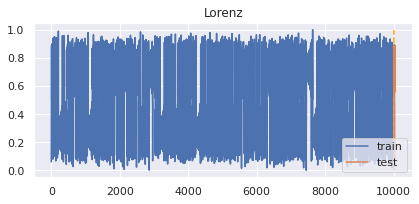

In [7]:
fig = plt.figure(figsize=[6, 3])
plt.plot(X_train, label='train')
plt.plot(range(split, split+steps), X_test, label='test')

plt.title('Lorenz')

plt.vlines(split, 0, 1,
           color='orange', linestyle='dashed')

plt.legend();
fig.tight_layout()

#### 1

In [8]:
tsp = TSProcessor(points_in_template, max_template_spread)

In [9]:
tsp.fit(x[:split])

In [10]:
forecast_sets = tsp.pull(
    steps=steps,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    n_jobs=-1
)

92.06s


In [11]:
# get a unified prediction at each point
result = tsp.cluster_sets(forecast_sets, dbs_eps, dbs_min_samples)
np.isnan(result).sum()

38

In [12]:
non_pred = np.cumsum(np.isnan(result).astype(int))
pred = np.cumsum(1 - np.isnan(result).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((result - X_test)**2), nan=0)) /pred

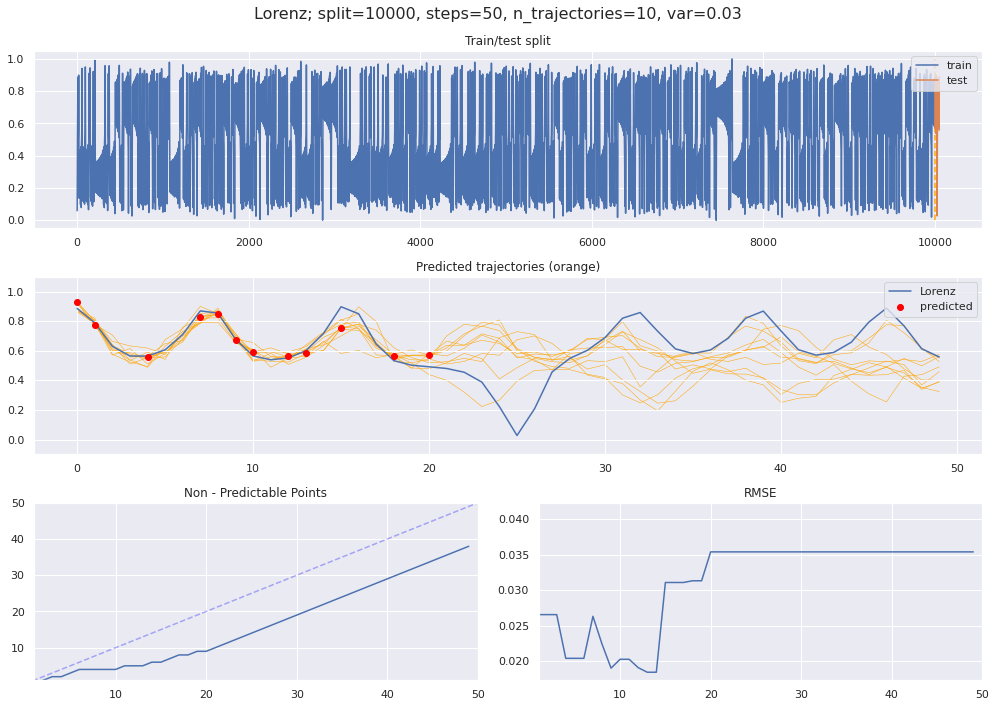

In [13]:
diag_plot(
    X_train, X_test,
    split, steps, noise_amp, n_trajectories,
    forecast_sets, result, non_pred, rmse, filename='lorenz/heal_before.png')

#### 2

In [44]:
forecast_sets = tsp.pull(
    steps=steps,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    prev_result=result,
    random_seed=2,
    n_jobs=-1
)

65.81s


In [45]:
# get a unified prediction at each point
new_result = tsp.cluster_sets(forecast_sets, dbs_eps, dbs_min_samples)
np.isnan(new_result).sum()

29

In [46]:
result[np.isnan(result)] = new_result[np.isnan(result)]

In [47]:
non_pred = np.cumsum(np.isnan(result).astype(int))
pred = np.cumsum(1 - np.isnan(result).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((result - X_test)**2), nan=0)) /pred

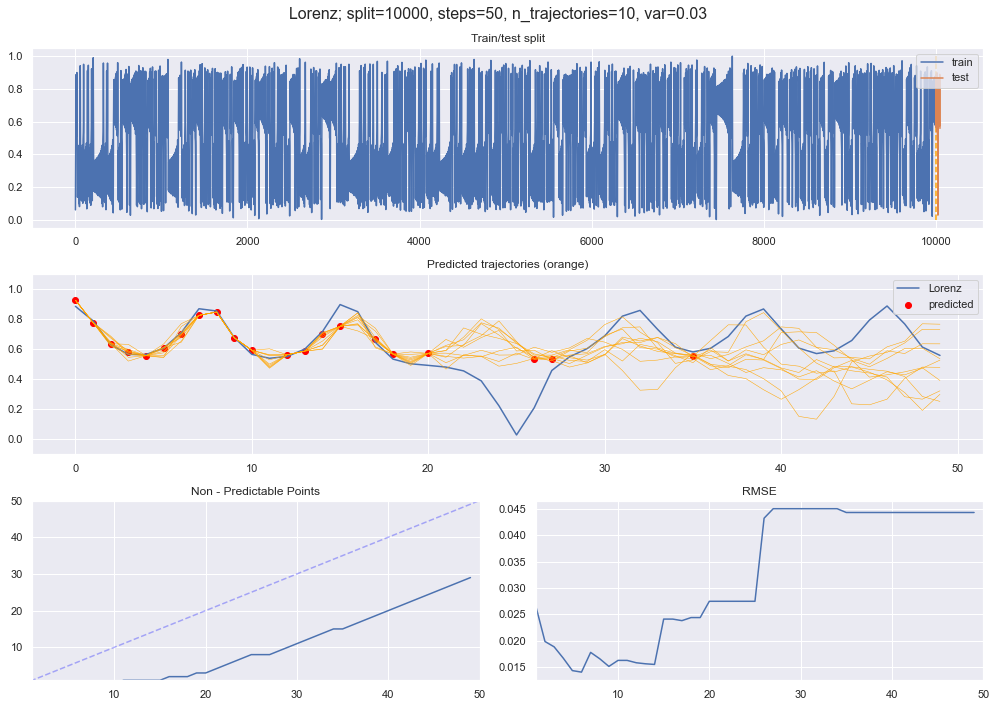

In [48]:
diag_plot(
    X_train, X_test,
    split, steps, noise_amp, n_trajectories,
    forecast_sets, result, non_pred, rmse, filename='lorenz/heal_after1.png')

#### 3

In [49]:
forecast_sets = tsp.pull(
    steps=steps,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    prev_result=result,
    random_seed=3,
    n_jobs=-1
)

57.78s


In [50]:
# get a unified prediction at each point
new_result = tsp.cluster_sets(forecast_sets, dbs_eps, dbs_min_samples)
np.isnan(new_result).sum()

23

In [51]:
result[np.isnan(result)] = new_result[np.isnan(result)]

In [52]:
non_pred = np.cumsum(np.isnan(result).astype(int))
pred = np.cumsum(1 - np.isnan(result).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((result - X_test)**2), nan=0)) /pred

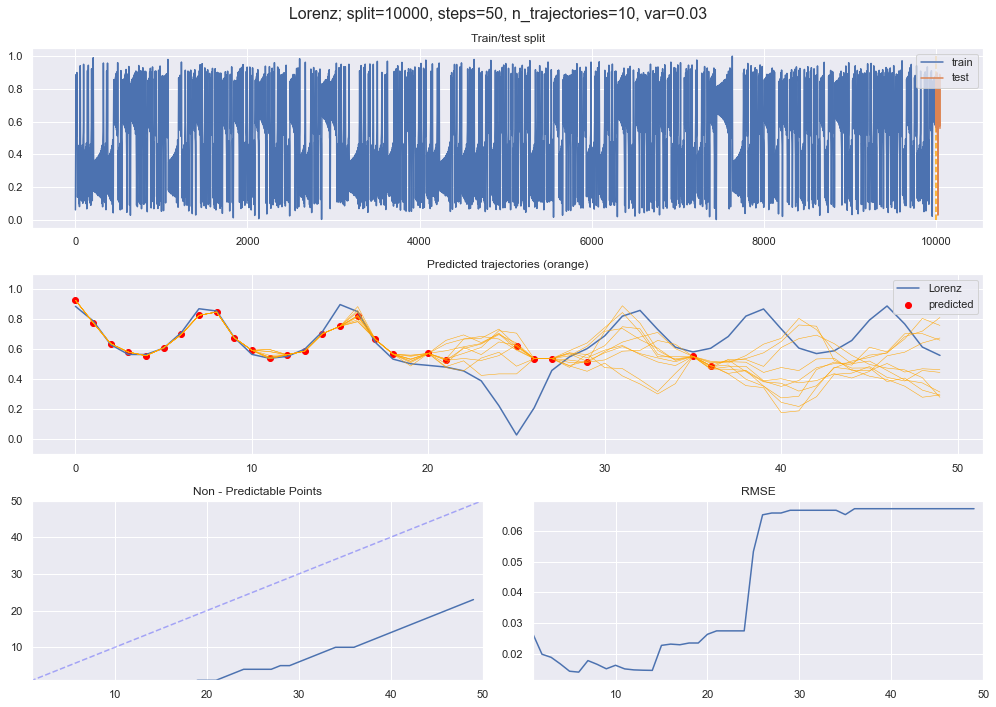

In [53]:
diag_plot(
    X_train, X_test,
    split, steps, noise_amp, n_trajectories,
    forecast_sets, result, non_pred, rmse, filename='lorenz/heal_after2.png')

### Quantiles

In [67]:
split = 10000

steps = 50
eps   = 0.01
n_trajectories = 32
noise_amp = 0.03

dbs_eps = 0.01
dbs_min_samples = 4

In [68]:
x, _, _ = Lorentz().generate(0.1, 3000+split+steps)
x, x_min, x_max = normalize(x[3000:]) # "For the Lorenz series, the first 3000 observations are discarded..."

In [69]:
X_train = x[:split]
X_test = x[split:split + steps]

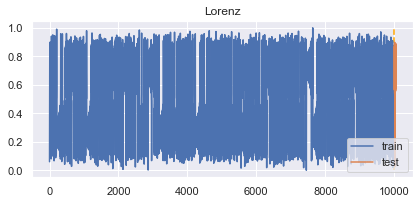

In [70]:
fig = plt.figure(figsize=[6, 3])
plt.plot(X_train, label='train')
plt.plot(range(split, split+steps), X_test, label='test')

plt.title('Lorenz')

plt.vlines(split, 0, 1,
           color='orange', linestyle='dashed')

plt.legend();
fig.tight_layout()

In [71]:
tsp = TSProcessor(4, 10)

In [72]:
tsp.fit(x[:split])

In [73]:
forecast_sets = tsp.pull(
    steps=steps,
    eps=eps,
    n_trajectories=n_trajectories,
    noise_amp=noise_amp,
    n_jobs=-1
)

382.57s


In [106]:
# get a unified prediction at each point
result = tsp.get_quantile_prediction(forecast_sets, max_err=0.1, alpha=0.1)
np.isnan(result).sum()

0 0.8631350483807675 0.9261490119970692 0.06301396361630174
1 0.7454317130783935 0.8201416524937056 0.07470993941531212
2 0.6015268464156505 0.6658538130432444 0.06432696662759396
3 0.5105651529517918 0.5927611500680668 0.08219599711627501
4 0.5128368101996444 0.5909371872569646 0.0781003770573202
5 0.5578010995635447 0.6467724435153674 0.08897134395182271
6 0.6665611680475613 0.7438869392270302 0.07732577117946893
7 0.7935599504712042 0.8819524657069306 0.08839251523572644
8 0.8128751112770077 0.8719114215826308 0.05903631030562306
9 0.6508505550252899 0.730658254891001 0.07980769986571112
10 0.5406514595018593 0.6101640963301902 0.06951263682833086
11 0.52380747520609 0.5932094011510006 0.06940192594491068
12 0.5137221055415442 0.597522106306626 0.08380000076508187
13 0.5256312523458829 0.6388821986293823 0.11325094628349941
14 0.6010479259974133 0.7753733953837902 0.17432546938637694
15 0.6754589310895591 0.8477649983829667 0.17230606729340758
16 0.7032793050883733 0.822601362031991

36

In [107]:
non_pred = np.cumsum(np.isnan(result).astype(int))
pred = np.cumsum(1 - np.isnan(result).astype(int))
pred[pred == 0] = 1
rmse = np.cumsum(np.nan_to_num(np.sqrt((result - X_test)**2), nan=0)) /pred

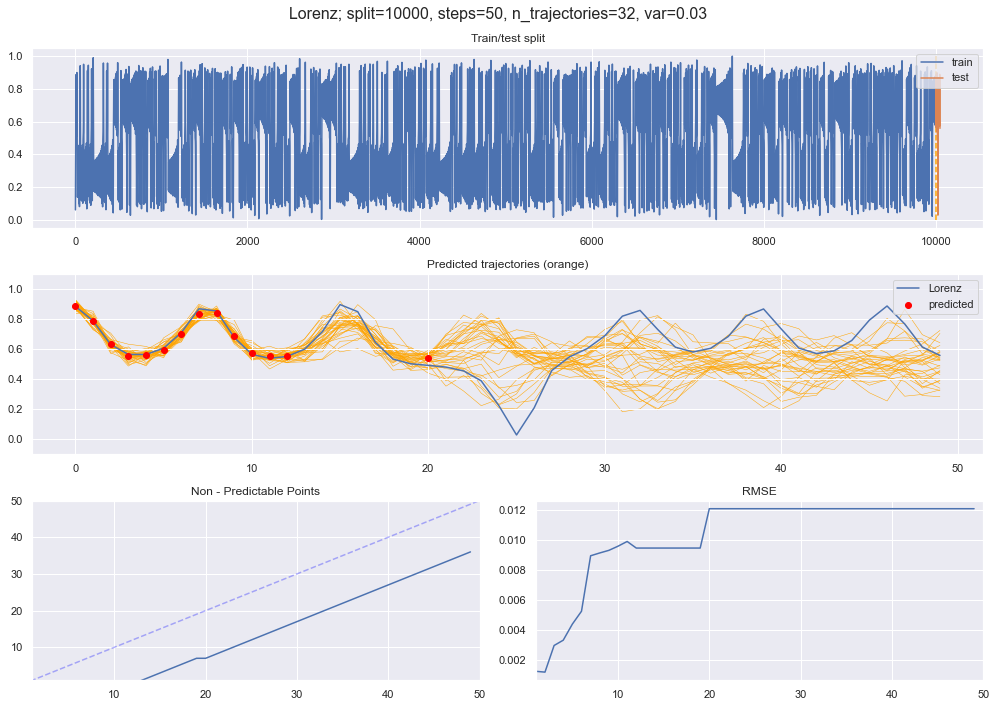

In [108]:
diag_plot(
    X_train, X_test,
    split, steps, noise_amp, n_trajectories,
    forecast_sets, result, non_pred, rmse, filename=f'lorenz/quantile_pred_{n_trajectories}.png')